(16, 16)
0.23849844932556152
0.9023913912598939
(64, 64)
0.09004974365234375
0.9902417941889445
(128, 128)
0.15457606315612793
0.9933608611619383
(256, 256)
0.39620518684387207
0.9951472789316537
(1024, 1024)
5.6352150440216064
0.9950030174160674
(4096, 4096)
96.97155547142029
0.9948321753628869


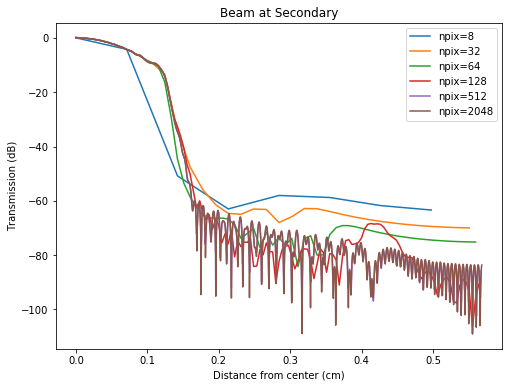

In [3]:
#This block will test what value of npix is necessary for a convergent simulation 
# From running on Hamilton, 2**11 seems sufficient past primary @ balloon

import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

npixels=[2**3, 2**5, 2**6, 2**7, 2**9, 2**11]

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.199 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 
tertiary_trunc = poppy.CircularAperture(radius=8*u.cm)
trex = poppy.CircularAperture(radius=4*u.cm)
secondary_trunc = poppy.CircularAperture(radius=14.697*u.cm)
primary_trunc = poppy.CircularAperture(radius=40*u.cm)

# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

plt.figure(figsize=(8,6))

for npixit in npixels:  
    tic=time.time()
    
    wf = poppy.FresnelWavefront(beam_radius=8.1*u.cm, wavelength=ll, npix=npixit) 

    wf *= lenslet_aperture
    
    wf *= coldstop
    initial_power=np.sum(wf.intensity)

    wf.propagate_fresnel(0.35*u.cm)
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle

    wf.propagate_fresnel(d_lens_3-baffle_z_array[-1]) #propagate to center of tertiary
   
    wf *= tertiary_obj
    wf *= tertiary_trunc

    wf.propagate_fresnel(d_IF) 
    
    wf *= trex
    
    wf.propagate_fresnel(d_3_2-d_IF)
    
    y, x = wf.coordinates()
    print(x.shape)
    z = wf.intensity
    #array_length = z.shape[0]
    half_array_length = int(z.shape[0]/2)

    plt.plot(x[half_array_length,half_array_length:],10*np.log10(z[half_array_length,half_array_length:]),
            label='npix='+str(npixit))
    print(time.time()-tic)
    print(np.sum(z)/initial_power)
    
plt.title('Beam at Secondary')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
#plt.xlim((0,0.15))
#plt.ylim((-2,0))
#plt.yscale('log')
plt.legend()
plt.show()


In [2]:
# This block will test how poppy handles power

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import poppy
from poppy.wfe import WavefrontError
from astropy.units import cds

fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m 
lenslet_aperture = poppy.GaussianAperture(fwhm=fwhm_)
ff = 480*u.GHz # 420-540GHz
ll = const.c/ff
d_lenslet_lens = 24*u.cm

npixels=[2**10]

# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.199 * u.cm
tertiary_obj = poppy.QuadraticLens(f_lens=f_3)
secondary_obj = poppy.QuadraticLens(f_lens=f_2)
primary_obj = poppy.QuadraticLens(f_lens=f_1)

#Radii
coldstop = poppy.CircularAperture(radius=3.81*u.cm)
baffle = poppy.CircularAperture(radius=3.874*u.cm) 
tertiary_trunc = poppy.CircularAperture(radius=8*u.cm)
secondary_trunc = poppy.CircularAperture(radius=14.697*u.cm)
primary_trunc = poppy.CircularAperture(radius=40*u.cm)


# separations 
d_lens_3 = 33.06 * u.cm
d_3_2 = 86.562 * u.cm
d_IF = 19.2 * u.cm
d_2_1 = 104.995 * u.cm

# position of baffles above lens in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

for npixit in npixels:   
    
    wf = poppy.FresnelWavefront(beam_radius=8.1*u.cm, wavelength=ll, npix=npixit) 
    print(np.sum(wf.intensity))
                     
    wf *= coldstop
    y, x = wf.coordinates()
    initial_power=np.sum(wf.intensity)
    print(np.sum(wf.intensity))
    
    wf *= lenslet_aperture
    print(np.sum(wf.intensity))
    
    wf.propagate_fresnel(0.35*u.cm)
    print(np.sum(wf.intensity))
        
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf.propagate_fresnel(baffle_z)
            print(np.sum(wf.intensity))
        else:
            wf.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf*=baffle
        print(np.sum(wf.intensity))

    wf.propagate_fresnel(d_lens_3-baffle_z_array[-1]) #propagate to center of tertiary
    print(np.sum(wf.intensity))
    
    wf *= tertiary_obj
    print(np.sum(wf.intensity))
    
    wf *= tertiary_trunc
    print(np.sum(wf.intensity))    
    
    wf.propagate_fresnel(d_IF) 
    print(np.sum(wf.intensity))
        
    trex = poppy.CircularAperture(radius=4*u.cm)
    wf *= trex
    print(np.sum(wf.intensity))
    
    wf.propagate_fresnel(d_3_2-d_IF)
    print(np.sum(wf.intensity))
    
    wf *= secondary_obj
    print(np.sum(wf.intensity))
    wf *= secondary_trunc
    print(np.sum(wf.intensity))
    wf.propagate_fresnel(d_2_1)
    print(np.sum(wf.intensity))
    
    wf *= primary_obj
    print(np.sum(wf.intensity))
    
    wf *= primary_trunc
    print(np.sum(wf.intensity))
    wf.propagate_fresnel(150*u.m)
    print(np.sum(wf.intensity))
    
            


1048576.0
181959.21637592505


MemoryError: Unable to allocate 64.0 MiB for an array with shape (2048, 2048) and data type complex128